In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import pandas as pd
import os
import numpy as np
from shapely.geometry import Polygon, LineString, Point, MultiLineString, mapping, MultiPolygon
from shapely.ops import cascaded_union
import pyproj
from shapely.ops import transform
from osgeo import gdal, ogr
import requests
import io
import yaml
import pickle
import logging
import functools
import folium
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

In [2]:
def linestring_to_polygon(gdf):
    geom = [x for x in gdf.geometry]
    all_coords = mapping(geom[0])['coordinates']
    lats = [x[1] for x in all_coords]
    lons = [x[0] for x in all_coords]
    polyg = Polygon(zip(lons, lats))
    return gpd.GeoDataFrame(index=[0], crs=gdf.crs, geometry=[polyg])

In [3]:
path = os.getcwd()

In [4]:
water_areas = []
for file_water_area in os.listdir(path+"\\geofiles\\water_areas"):
    if file_water_area.endswith((".geojson")):
        water_areas.append(gpd.read_file(path+"\\geofiles\\water_areas\\"+file_water_area))
water_areas_df = pd.concat(water_areas)

In [5]:
# srcDS = gdal.OpenEx(path+'\\geofiles\\locks\\Sluizencomplex IJmuiden.kml')
# ds = gdal.VectorTranslate(path + '\\geofiles\\locks\\Sluizencomplex_IJmuiden.geojson', srcDS, format='GeoJSON')
locks = []
for file_lock in os.listdir(path+"\\geofiles\\locks"):
    if file_lock.endswith((".geojson")):
        locks.append(gpd.read_file(path+"\\geofiles\\locks\\"+file_lock))
locks_df = pd.concat(locks)
for loc,info in locks_df.iterrows():
    sluices_linestrings = info.geometry
sluices = []
for sluice_linstring in sluices_linestrings.geoms:
    sluices.append(Polygon(shapely.ops.transform(lambda x, y, z=None: (x, y), sluice_linstring)))
sluices = gpd.GeoDataFrame(data={'Name':['Zeesluis','Noordersluis','Middensluis','Zuidersluis','Kleine Sluis']},geometry=sluices,crs='EPSG:4326')

In [6]:
traffic_separation_scheme = []
for file_water_area in os.listdir(path+"\\geofiles\\traffic_separation_scheme"):
    traffic_separation_scheme.append(gpd.read_file(path+"\\geofiles\\traffic_separation_scheme\\"+file_water_area))
traffic_separation_scheme_df = pd.concat(traffic_separation_scheme)
traffic_separation_scheme_df = traffic_separation_scheme_df.drop(index=16)

In [7]:
anchorage_areas = []
for file_anchorage_area in os.listdir(path+"\\geofiles\\anchorage_areas"):
    anchorage_areas.append(gpd.read_file(path+"\\geofiles\\anchorage_areas\\"+file_anchorage_area))
anchorage_areas_df = pd.concat(anchorage_areas)

In [8]:
water = []
for _,area in water_areas_df[['geometry']].iterrows():
    geometry = area.iloc[0]
    water.append(geometry)
water = cascaded_union(water)

C:\Users\floorbakker\AppData\Local\Temp\ipykernel_38208\3160590025.py:5: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  water = cascaded_union(water)


In [9]:
terminal_areas = []
for file_terminal_area in os.listdir(path+"\\geofiles\\terminal_areas"):
    terminal_areas.append(gpd.read_file(path+"\\geofiles\\terminal_areas\\"+file_terminal_area))
terminal_areas_df = pd.concat(terminal_areas)
terminal_areas_df = terminal_areas_df.reset_index(drop=True)
cruise_terminal_amsterdam = linestring_to_polygon(terminal_areas_df.loc[22:31])
cruise_terminal_amsterdam_berth = linestring_to_polygon(terminal_areas_df.loc[[27]])
cruise_terminal_amsterdam = pd.concat([cruise_terminal_amsterdam,cruise_terminal_amsterdam_berth])
terminal_areas_df = terminal_areas_df.drop(index=np.arange(22,32))
terminal_areas_df = pd.concat([terminal_areas_df,cruise_terminal_amsterdam])
terminals_polygon = shapely.ops.unary_union([polygon for polygon in terminal_areas_df.geometry])
water_polygon = shapely.ops.unary_union([polygon for polygon in water_areas_df.geometry])
terminals_polygon = terminals_polygon.difference(water_polygon)
terminals = gpd.GeoDataFrame(geometry=[terminals_polygon],crs='EPSG:4326')

In [10]:
redundant_water_areas = []
for file_redundant_water_area in os.listdir(path+"\\geofiles\\water_areas\\redundant"):
    redundant_water_areas.append(gpd.read_file(path+"\\geofiles\\water_areas\\redundant\\"+file_redundant_water_area))
redundant_water_areas_df = pd.concat(redundant_water_areas)
redundant_water_areas_df = redundant_water_areas_df.reset_index(drop=True)
redundant_water_areas_df = redundant_water_areas_df.drop(index=list(np.append([0,1,2,3,4,5,6,7,8,16,17,18,19,20,21,22],np.arange(25,len(redundant_water_areas_df)))))
redundant_water_areas = shapely.ops.unary_union([polygon for polygon in redundant_water_areas_df.geometry]) 

In [11]:
water = water.difference(redundant_water_areas)

In [12]:
water = gpd.GeoDataFrame(data=[water],columns=['geometry'],crs='EPSG:4326')

In [13]:
tss_boundaries = traffic_separation_scheme_df.iloc[[9,10,11,13,14]]
for loc,info in tss_boundaries.iterrows():
    tss_boundaries.loc[loc,'geometry'] = Polygon(info.geometry)

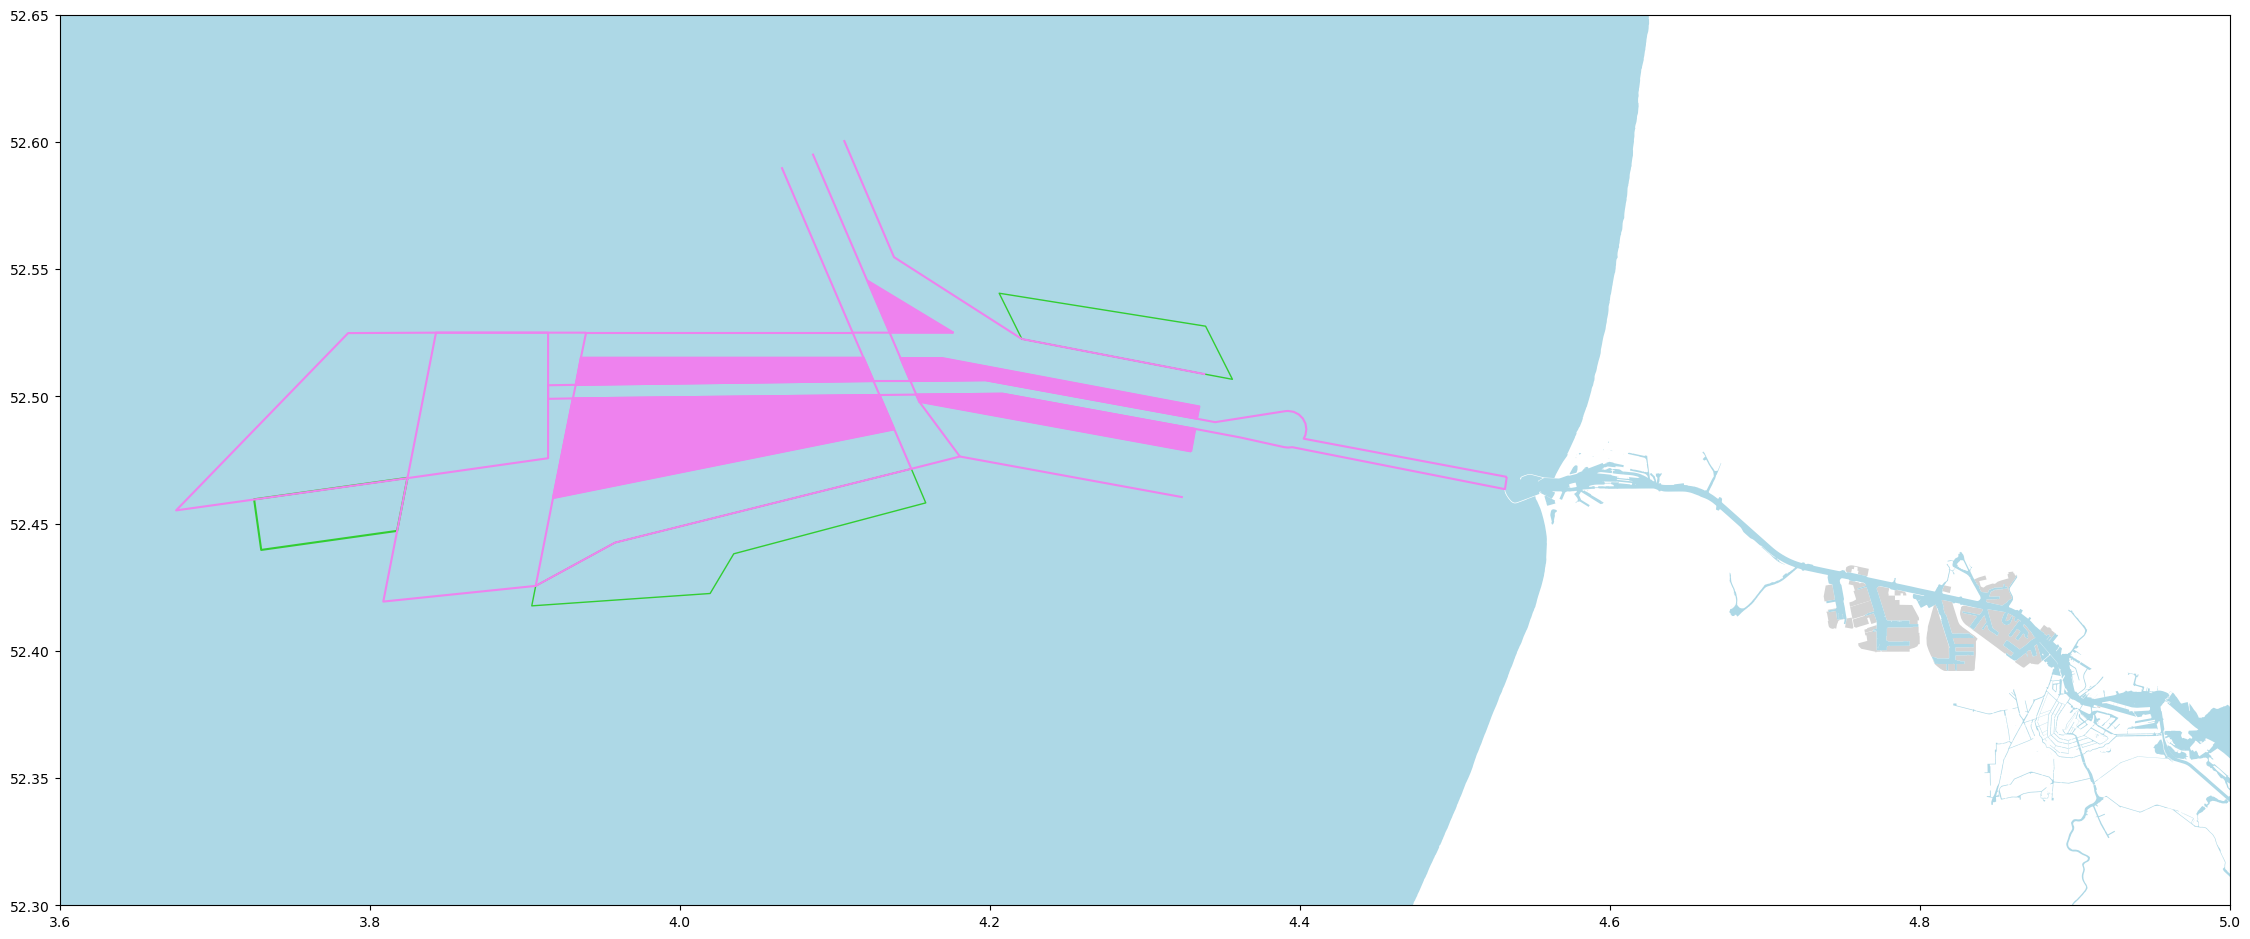

In [14]:
fig,ax = plt.subplots(figsize=[28,18])
terminals.plot(ax=ax,facecolor='lightgrey')
water.plot(ax=ax,facecolor='lightblue',edgecolor='none')
traffic_separation_scheme_df.plot(ax=ax,edgecolor='violet')
tss_boundaries.plot(ax=ax,edgecolor='violet',facecolor='violet')
anchorage_areas_df.plot(ax=ax,edgecolor='limegreen',facecolor='none',zorder=1)
#sluices.plot(ax=ax,facecolor='none',edgecolor='k')
ax.set_xlim([3.6,5.0])
ax.set_ylim([52.30,52.65]);

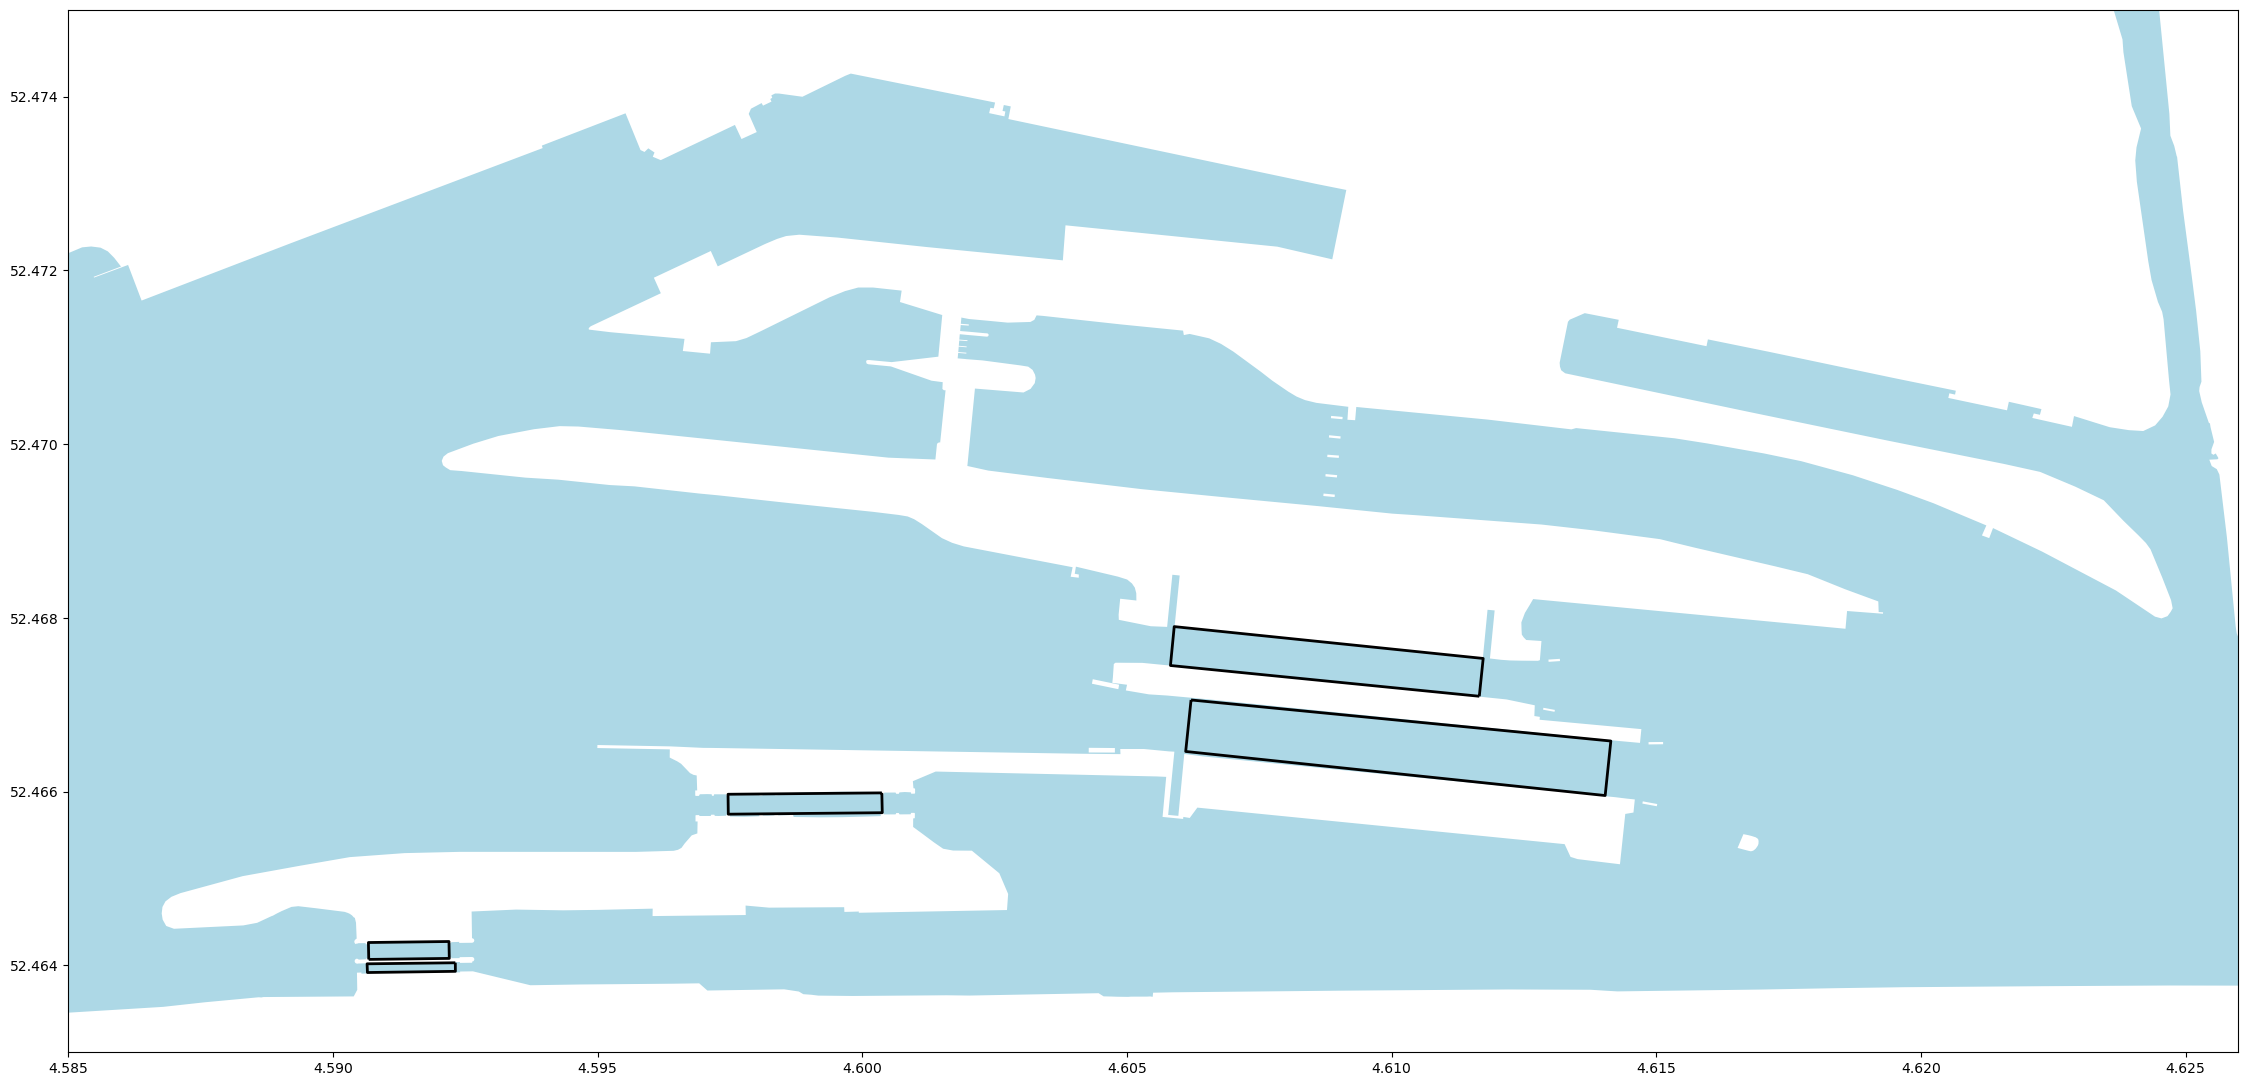

In [15]:
fig,ax = plt.subplots(figsize=[28,18])
water.plot(ax=ax,facecolor='lightblue')
traffic_separation_scheme_df.plot(ax=ax,edgecolor='violet')
tss_boundaries.plot(ax=ax,edgecolor='violet',facecolor='violet')
anchorage_areas_df.plot(ax=ax,edgecolor='limegreen',facecolor='none',zorder=1)
sluices.plot(ax=ax,facecolor='none',edgecolor='k',linewidth=2)
ax.set_xlim([4.585,4.626])
ax.set_ylim([52.463,52.475]);

In [16]:
data = pd.read_csv(path+"\\hydrodynamic_data\\discharges_lobith_2022.csv",delimiter=';')

In [17]:
data = data[data['WAARDEBEPALINGSMETHODE_CODE'] == 'other:F216']
disch_data = data[['WAARNEMINGDATUM','WAARNEMINGTIJD (MET/CET)','ALFANUMERIEKEWAARDE']]
disch_data = disch_data.rename({'WAARNEMINGDATUM':'Date','WAARNEMINGTIJD (MET/CET)':'Time','ALFANUMERIEKEWAARDE':'Discharge'},axis=1)

In [18]:
disch_data['Datetime'] = disch_data['Date']+' '+disch_data['Time']
disch_data['Datetime'] = pd.to_datetime(disch_data['Datetime'],format='%d-%m-%Y %H:%M:%S')
disch_data = disch_data[['Datetime','Discharge']]
disch_data = disch_data[disch_data['Discharge'] < 20000]

In [19]:
moving_averaged_disch_data = disch_data.rolling(window=pd.Timedelta(24,'h'),on='Datetime').mean()

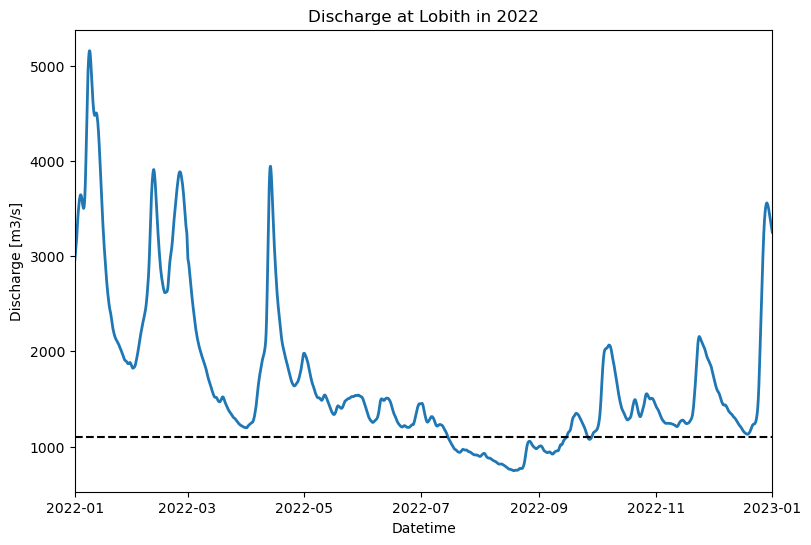

In [20]:
fig,ax = plt.subplots(figsize=[9,6])
plt.plot(moving_averaged_disch_data['Datetime'],moving_averaged_disch_data['Discharge'],linewidth=2)
plt.axhline(1100,color='k',linestyle='--')
plt.xlim(pd.Timestamp('2022-01'),pd.Timestamp('2023-01'))
plt.xlabel('Datetime')
plt.ylabel('Discharge [m3/s]')
plt.title('Discharge at Lobith in 2022');

In [21]:
@functools.lru_cache
def load_fis_network(url):
    """load the topological fairway information system network (vaarweginformatie.nl)"""

    # get the data from the url
    resp = requests.get(url)
    # convert to file object
    stream = io.StringIO(resp.text)
    
    # This will take a minute or two
    # Here we convert the network to a networkx object
    G = yaml.load(stream, Loader=yaml.Loader)

    # some brief info
    n_bytes = len(resp.content)
    msg = '''Loaded network from {url} file size {mb:.2f}MB. Network has {n_nodes} nodes and {n_edges} edges.'''
    summary = msg.format(url=url, mb=n_bytes / 1000**2, n_edges=len(G.edges), n_nodes=len(G.nodes))
    logger.info(summary)

    # The topological network contains information about the original geometry. 
    # Let's convert those into python shapely objects for easier use later
    for n in G.nodes:
        G.nodes[n]['geometry'] = shapely.geometry.Point(G.nodes[n]['X'], G.nodes[n]['Y'])
    for e in G.edges:
        edge = G.edges[e]
        edge['geometry'] = shapely.wkt.loads(edge['Wkt'])
    
    return G